# Code Challenge: Text classification

In [116]:
import pandas as pd
import json as js
import numpy as np
import seaborn as sns
import spacy
import pickle
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
plt.rcParams["figure.figsize"]=20,8

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

In [2]:
Version = !python --version
assert(Version == ['Python 3.8.0'])

In [137]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuakraft/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Data

In [3]:
json_file = 'tech_soft_none.json'
Json = js.load(open(json_file,))
df = pd.DataFrame(Json['data'])

In [4]:
p_id = {k: v for v, k in enumerate(df.label.unique())}
df['num_label'] = df['label'].apply(lambda label: p_id[label])

In [5]:
df.head(10)

,text,label,num_label
0,"Standort Trovarit AG München, Deutschland",none,0
1,Wir freuen uns auf Ihre Bewerbung unter Angabe Ihrer Gehaltsvorstellung und Ihres möglichen Eintrittstermins. Der ALTE LEIPZIGER – HALLESCHE Konzern begrüßt ausdrücklich die Bewerbung von Menschen...,none,0
2,Qualifikation zur Heimleitung gemäß Heimpersonalverordnung,tech,1
3,Gute organisatorische und konzeptionelle Fähigkeiten,soft,2
4,"Teamfähigkeit, hohe Flexibilität und Einsatzbereitschaft.",soft,2
5,Überdurchschnittliche Einsatzbereitschaft,soft,2
6,HomeIhre Karriere bei LeasePlanStellenangeboteSachbearbeiter/in Vertriebskoordination Händlerbetreuung LeasePlan SME,none,0
7,Steuerkenntnisse sind sehr wünschenswert,tech,1
8,Kreativität und schnelle Auffassungsgabe,soft,2
9,budget/forecast/prior year/prior month) and provide explanations for the management,none,0


## Data Exploration

#### Class distribution

I'm gonna look for the class distribution to get a sense of any imbalances in the data

Text(0, 0.5, 'frequency')

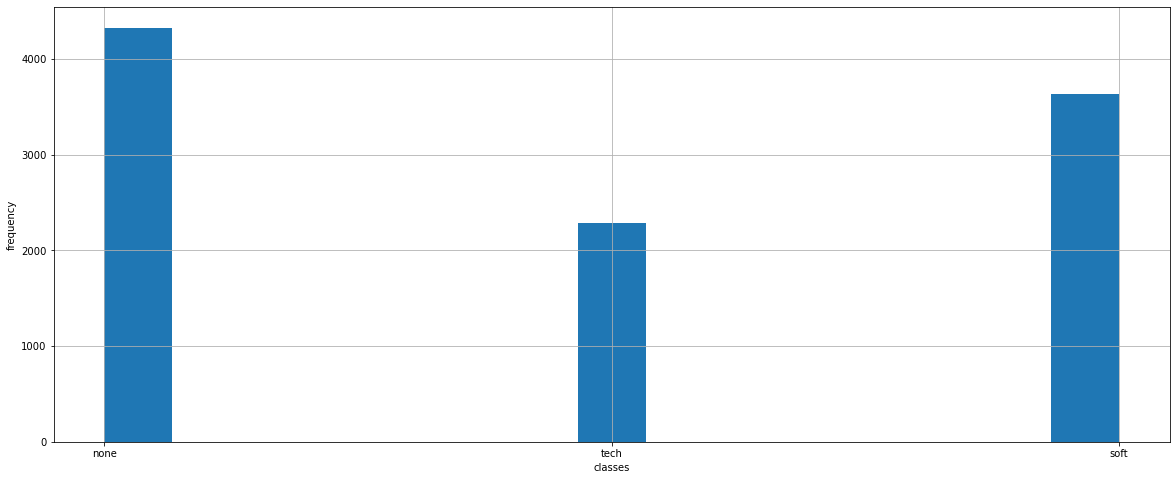

In [6]:
class_distribution = df['label'].hist(bins=15)
class_distribution.set_xlabel("classes")
class_distribution.set_ylabel("frequency")

I probably won't use **over-** or **undersampling** because the classes are reasonably balanced. 

<h1><center>$\frac{set_{smallest}}{set_{largest}} \approx 0.6$</center></h1>

#### Senctence length

I'm gonna look for the average sentence length to get a feel for the dimentionality of the data and the feature extraction down the line. How many data points have a sentence length below [10, 20, 30]? Are there outliers? This would be important to know if I would use padding.

In [7]:
#approximate since a seperation by space doesn't always apply
approx_len = lambda sentence: len(sentence.split())
df['sentence_length'] = df['text'].apply(approx_len)

Text(0, 0.5, 'frequency')

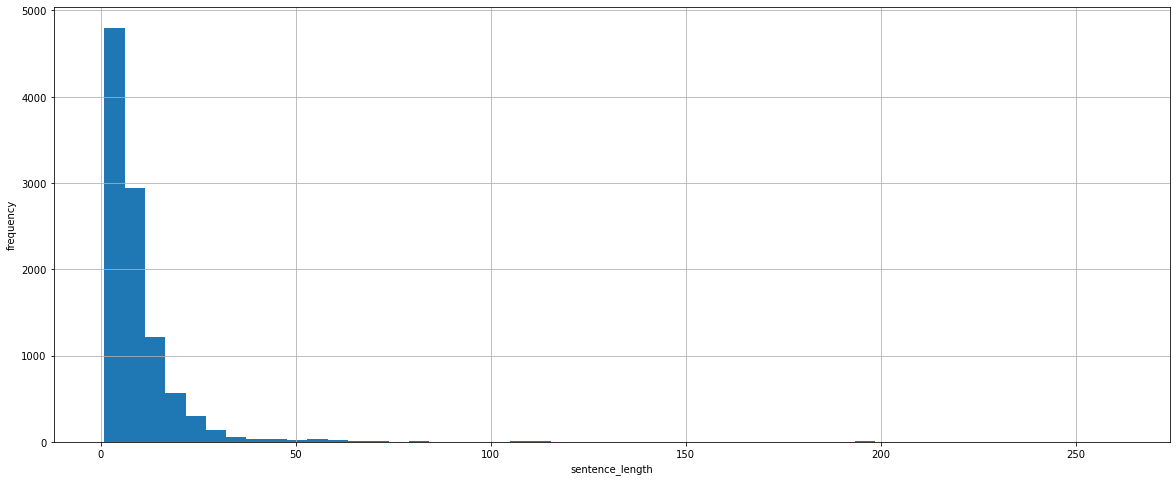

In [8]:
sentence_length = df['sentence_length'].hist(bins=50)
sentence_length.set_xlabel("sentence_length")
sentence_length.set_ylabel("frequency")

## 1.  Feature extraction

Which problems could occure?
* German: Umlauts, compound words
* In general: numeric characters, special characters, stopwords

### Defining stopwords

First we define our stopwords for our dataset. In this case we use a german corpus by NLTK. In this case we have to manuelly replace all umlauts, so that they will match the allready processed tokens later.

In [10]:
def replace_umlauts(s):
    for old, new in [('ü','u'), ('ö','o'), ('ä','a')]:
        s = s.replace(old, new)
    return s

In [9]:
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
german_stop_words = [replace_umlauts(word) for word in german_stop_words]

### Preprocessing

Here I tried to lemmatize and preprocess the tokens, since some of the sentence contain enumerations of qualifications etc.. It turned out, that this preprocessing didn't have a positive effect on the metrics.

In [41]:
'''nlp = spacy.load('de', disable=["tagger", "parser","ner"])

def preprocessing(tok):
    tok = tok.lower()
    
    doc = nlp(tok)
    if len(doc) == 1:
        tok = doc[0].lemma_
        
    tok = replace_umlauts(tok)
        
    return tok
    
preprocessing('Fähigkeiten')'''

### Text representation

All other issues will resolve in this chapter, since I will use a text representation method which contains several handy tools. I could remove my own preprocessing and fully integrate it in this optimized version of a freature extractor. 

#### Train-Test Split

I split the data beforehand to ensure the extractor only rely on the trainig data

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['num_label'],
                                                    test_size=0.2)

#### Tf-IDF

This is my key-decision on how to preprocess and represent my text data. Here i chose to use a fixed length, no padding and order invariante method. This is because the important information is contained in keyword and -phrases regardless of the order. For this reason I will use this more sophisticated BagOfWords-approach. I will comment on each component to make my choice more clear.

In [98]:
tfidf = TfidfVectorizer(analyzer="word", #this is obvious, but the important instance of this classifier are words
                        strip_accents='ascii', #this step comes in handy to stip all umlauts automtically
                        lowercase=True, #beeing case sensitive would only increase our dimention without adding information 
                        stop_words=german_stop_words, #here i incorporate my stopwords
                        min_df = 2, #I want a great understanding of the wordbase without including tokens only appearing once like company names (entities) etc.
                        smooth_idf=True, #prevents zero divisions
                        encoding='utf-8', #my preferred encoding
                        ngram_range=(1,2), #this is really important! here i choose to build up the vocab with uni- and bigrams, since many keyphrases consist of one or more words  
                        max_features=10000, #this cap gives me a reasonably dimentionality by still cutting out the lower end of words and phrases which would lead overfitting behaviour 
                        token_pattern = r'[a-z]+' #here I chose to drop any non alphabetic tokens, since they wont hold any reasonable information on this task
                        )

In [99]:
X_train = tfidf.fit_transform(X_train)

In [113]:
assert(len(tfidf.get_feature_names()) == 10000)

This is my final fearture extration which is trained on the training data

In [101]:
def feature_extraction(X):
    return tfidf.transform(X)

## 2. Training

I chose to use a Naive Bayes (NB) classifier because it is the most straight foreward way for a BagOfWords representation. This is because we can assume statstical independence of the idividual features since we have a positoin invariant representation. Which makes training fast and easy and keeps the models complexitiy reasonable.

In [102]:
clf = MultinomialNB(fit_prior=True).fit(X_train, y_train)

I did not implement another model like Logistic Regression or Neuraln Networks since i did not expect any performance improvments. I kept it simple.

In [103]:
def predict(X):
    return clf.predict(X)

## 3. + 4. Evaluation

In this section I will explore my models performance by looking at the confusion matrix and the deducible metrics. The confusion matrix will give me a good feel for the classification of my model. I can check for imbalances and overfitting. The accuracy is my main indicator of performanced and backed up by Precision and Recall for each individual class (There shoudn't be outliers).

In [104]:
def evaluate(X_test, y_test):
    
    X_test = feature_extraction(X_test)
    y_pred = predict(X_test)
    
    conf = confusion_matrix(y_test, y_pred)
    
    #percentage of texts that were categorized with the correct tag
    accuracy = conf.trace()/conf.sum()
    #percentage of examples the classifier got right out of the total number of examples that it predicted for a given tag
    precision =  np.diagonal(conf) / conf.sum(axis=0)
    #percentage of examples the classifier predicted for a given tag out of the total number of examples it should have predicted for that given tag
    recall = np.diagonal(conf) / conf.sum(axis=1) 
    
    print('------------------------\n' +
          f'Accuracy: {accuracy}\n' +
          f'Precision: {precision}\n' +
          f'Recall: {recall}\n' +
          '------------------------')    
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(conf, annot=True, fmt='d',
                xticklabels=p_id.keys(),
                yticklabels=p_id.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    def get_false_classified(true, pred):
        wrong_indices = [i for i, cls in enumerate(y_pred) if
                         cls == p_id[pred] and y_test.iloc[i] == p_id[true]]
        df_indices = y_test.index[wrong_indices]
        false_classified = df[['text', 'label']].loc[df_indices]
        return false_classified
    
    
    wrong_tech_soft = get_false_classified('tech', 'soft')
    wrong_soft_tech = get_false_classified('soft', 'tech')
    
    return wrong_tech_soft, wrong_soft_tech

### Confusion Matrix

The results look very nice, since we archived a great accuracy of 95% of the training data lieing on the diagonal. The wrongly classified ecamples are spread evenly and can be explained by random varaince. But to get a better understanding of what's going on I will always look at a few missclassified examples.

------------------------
Accuracy: 0.953170731707317
Precision: [0.96501129 0.94621027 0.94304636]
Recall: [0.96501129 0.90632319 0.9660787 ]
------------------------


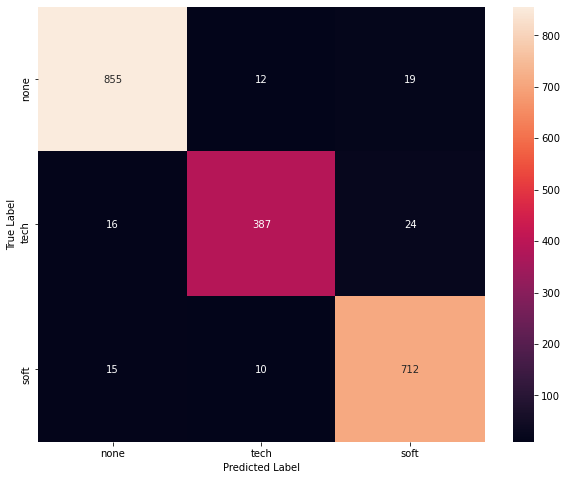

In [105]:
wrong_tech_soft, wrong_soft_tech  = evaluate(X_test, y_test)

### Looking at false classified

In [106]:
wrong_tech_soft.head(15)

,text,label
3188,Die obligatorischen MS Office Kenntnisse sowie sehr gute kommunikative Fähigkeiten runden Ihr Profil ab.,tech
110,"Spaß und Kompetenz in der Konzeptentwicklung, der Strukturierung von Prozessen und der Verschriftlichung von Texten haben",tech
1415,gern Verantwortung übernehmen,tech
1732,Beharrlichkeit in der Verfolgung von Zielen.,tech
2551,"Besitz des Führerscheins der Klasse B sowie die Bereitschaft, einen privaten PKW als dienstlich anerkanntes Fahrzeug einzusetzen",tech
2887,wertschätzende Einstellung zur Elternarbeit,tech
7081,"Hohe Motivation und Begeisterung, um sich schnell in ein neues Arbeitsgebiet einzuarbeiten",tech
3669,Kenntnisse in der Gruppenarbeit mit Kindern,tech
5908,Gute Englischkenntnisse in Wort und Schrift,tech
8498,"Sehr gute Kommunikationsfähigkeit, insbesondere im Bereich der Weitergabe von Wissen.",tech


In [107]:
wrong_soft_tech.head(15)

,text,label
4679,Handwerkliches Geschick,soft
7032,Gute Kenntnisse in Englisch und/oder Niederländisch sind wünschenswert,soft
1361,Projektmanagement-Fähigkeiten.,soft
6464,Interesse an aktuellen und neuen Techniken,soft
844,Kreativität und Begeisterung für Trends und Themen im digitalen Bereich,soft
760,sehr gutes Verständnis technischer Probleme und ihrer Zusammenhänge,soft
2064,Fundierte Kenntnisse in Microsoft Office und SharePoint,soft
927,Gute Kenntnisse im Projektmanagement,soft
135,Führerscheine: B (alt: FS3),soft
1306,Fundierte Englischkenntnisse.,soft


At this examples we can see that the models confusion is not only by random chance but also by attributes of the data. For example do they contain wrongly annoted data like 'Kenntnisse in der Gruppenarbeit mit Kinder' being labeld as 'tech' and 'Fundierte Kenntnisse in Microsoft Office und SharePoint' labeld as 'soft'. By this examples I do not see a great room for improvment based on this dataset. Nevertheless I would look a bit more into the preprocessing of the data.

### Further improvements

There are a few steps i would talk to further optimize the model:
* I would cross validate my hyperparametes
* I would try to deal with compound words like '...verständnis'

## 5. Saving the model

In [119]:
with open('model/classifier','wb') as file:
    pickle.dump(clf, file)

In [120]:
with open('model/feature_extractor','wb') as file:
    pickle.dump(tfidf, file)